In [10]:
from tqdm import tqdm, trange
import torch
import torchvision
from PIL import Image, ImageDraw
from torchvision import models
from torch.nn import functional as F
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imagesize
from torch.utils import data
import torch.optim as optim
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import os
from pathlib import Path
from torch.utils.data import SubsetRandomSampler,DataLoader,Dataset
import cv2
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
np.random.seed(0)
torch.manual_seed(0)

In [11]:
img_path = 'fold1_seperated_2_classes/test/100X/Malignant/SOB_M_DC-14-11520-100-002.png'
img = Image.open(img_path)

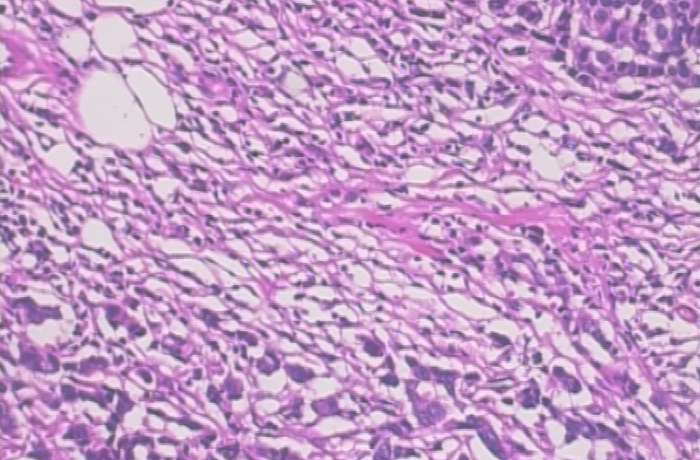

In [12]:
img

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
device

device(type='cuda')

In [15]:
training_dataset_path = 'fold1_seperated_2_classes/train/100X'
testing_dataset_path = 'fold1_seperated_2_classes/test/100X'

In [16]:
def train_transform():
  transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.7900, 0.6163, 0.7614],
                            std = [0.1038, 0.1382, 0.0885])
    ])
  return transform

In [17]:
transform = train_transform()

In [18]:
X = transform(img).unsqueeze_(0)

In [19]:
X.shape

torch.Size([1, 3, 512, 512])

In [20]:
def load_dataset(path,transform_img):
  data = torchvision.datasets.ImageFolder(root=path, transform=transform_img)
  return data

In [21]:
training_dataset = load_dataset(training_dataset_path,transform)
training_dataset

Dataset ImageFolder
    Number of datapoints: 1321
    Root location: fold1_seperated_2_classes/train/100X
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.79, 0.6163, 0.7614], std=[0.1038, 0.1382, 0.0885])
           )

In [22]:
testing_dataset = load_dataset(testing_dataset_path,transform)
testing_dataset

Dataset ImageFolder
    Number of datapoints: 760
    Root location: fold1_seperated_2_classes/test/100X
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.79, 0.6163, 0.7614], std=[0.1038, 0.1382, 0.0885])
           )

In [23]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 16,shuffle=True)

In [24]:
dataset_size = len(testing_dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.3 * dataset_size)) #0.2 - 20:80 Ratio
test_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_loader = torch.utils.data.DataLoader(dataset = testing_dataset,batch_size = 16,sampler=test_sampler,shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset= testing_dataset, shuffle=False, batch_size=16, sampler=val_sampler)

Vision Transformer Model

In [25]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"
    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [26]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [27]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.dropout = nn.Dropout(p=0,inplace=False)
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        result = []
        for idx,sequence in enumerate(sequences):
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                #print("attention shape NOw:",attention.shape)
                att = attention@v
                
                #print("Output Attention Shape:",att.shape)
                seq_result.append(att)
                
            result.append(torch.hstack(seq_result))
            res = torch.cat([torch.unsqueeze(r, dim=0) for r in result]) 
            res = self.dropout(res)
            #print('Res',res.shape)
            
        return res

In [28]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=3):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [29]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches, n_blocks, hidden_d, n_heads, out_d):
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)  #Patchify
        #print('Patch Shape',patches.shape)
        tokens = self.linear_mapper(patches)
        #print('Token shape',tokens.shape)
        #print('Clss Token Shape:',self.class_token.shape)
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        #print('Positional Embedding shape:',self.positional_embeddings.shape)
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        for block in self.blocks:
            out = block(out)
        #print('Out',out.shape)
        # Getting the classification token only
        out = out[:, 0]
        #print(out.shape)

        return self.mlp(out) #16,257,256

In [30]:
model = MyViT((3,512,512), n_patches=8, n_blocks=6, hidden_d=1024, n_heads=8, out_d=2).to(device)
N_EPOCHS = 100
LR = 0.0001
optimizer = optim.SGD(model.parameters(), lr=LR,momentum=0.9,weight_decay=0.03)
criterion = CrossEntropyLoss()

In [31]:
model

MyViT(
  (linear_mapper): Linear(in_features=12288, out_features=1024, bias=True)
  (blocks): ModuleList(
    (0-5): 6 x MyViTBlock(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mhsa): MyMSA(
        (q_mappings): ModuleList(
          (0-7): 8 x Linear(in_features=128, out_features=128, bias=True)
        )
        (k_mappings): ModuleList(
          (0-7): 8 x Linear(in_features=128, out_features=128, bias=True)
        )
        (v_mappings): ModuleList(
          (0-7): 8 x Linear(in_features=128, out_features=128, bias=True)
        )
        (dropout): Dropout(p=0, inplace=False)
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=1024, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=3072, out_features=1024, bias=True)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_featu

In [32]:
model(X.to(device))

tensor([[1.0878, 0.4450]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [33]:
def set_device():
  if torch.cuda.is_available():
    dev = 'cuda:0'
  else:
    dev = 'cpu'
  return torch.device(dev)

In [34]:
def train_nn(model, train_loader, test_loader,criterion,optimizer,n_epochs):
  device = set_device()
  best_acc = 0
  train_losses = []
  train_acc = []
  val_acc = []
  val_losses = []
  model = model.to(device)
  for epoch in range(n_epochs):
    print("Epoch number: %d"%(epoch+1))
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    for data in train_loader:
      images,labels = data
      images = images.to(device) #for faster processing
      labels = labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad() #Set grad = 0 before back prop
      outputs = model(images)

      _,predicted = torch.max(outputs.data,1)

      loss = criterion(outputs,labels)
      loss.backward() #Calculate Weight gradients
      optimizer.step() #update weights
      running_loss += loss.item()
      running_correct += (labels==predicted).sum().item()
      
    

    epoch_loss = running_loss/len(train_loader)
    epoch_acc = 100.0*running_correct/total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)

    print("  -Training Dataset, Got %d out of %d images correctly (%0.3f%%). Epoch Loss: %0.3f"%(running_correct, total, epoch_acc,epoch_loss))
    test_dataset_acc, test_dataset_loss = evaluate_model(model,test_loader,criterion)
    val_acc.append(test_dataset_acc)
    val_losses.append(test_dataset_loss) 

    if (test_dataset_acc>best_acc):
        best_acc = test_dataset_acc
        save_checkpoint(model,epoch,optimizer,best_acc)

  print('Finished Training')
  return model,train_losses,train_acc,val_acc,val_losses


def evaluate_model(model,test_loader,criterion):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    running_loss = 0.0

    with torch.no_grad(): #Used for not backpropogating which improves computation speed
          for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0) 

            outputs = model(images)

            _,predicted = torch.max(outputs.data,1)
            loss = criterion(outputs,labels)
            running_loss+=loss.item()

            predicted_correctly+=(predicted==labels).sum().item()
    epoch_acc = 100.0*predicted_correctly/total
    epoch_loss = running_loss/len(test_loader)
    print('-  Testing dataset. Got %d out of %d images correctly (%0.3f%%). Loss: %0.3f' % (predicted_correctly, total, epoch_acc,epoch_loss))

    return epoch_acc,epoch_loss


def save_checkpoint(model,epoch,optimizer, best_acc):
  state = {
      'epoch': epoch + 1,
      'model': model.state_dict(),
      'best accuracy': best_acc,
      'optimizer': optimizer.state_dict(),
  }
  torch.save(state,'Models/simplevit_model_combined_gnd.pth')

In [37]:
#Train the model
#history, train_losses, train_acc, val_acc, val_losses = train_nn(model, train_loader,val_loader, criterion, optimizer ,100)

In [38]:
model_path = 'Models/simplevit_model_combined_gnd.pth'
check = torch.load(model_path)

C:\Users\Utkarsh Varman\AppData\Local\Temp\ipykernel_16580\521532806.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check = torch.load(model_path)


In [39]:
check['best accuracy']

79.3859649122807

In [40]:
model.load_state_dict(check['model'])

<All keys matched successfully>

Explainability

In [118]:
def show_mask_on_image(img, mask):
    """
    Overlay a heatmap on an image based on the given mask.

    Parameters:
    - img: The original image (NumPy array, expected in BGR format for OpenCV).
    - mask: The attention mask (NumPy array, expected to be normalized).

    Returns:
    - cam: The combined image with the heatmap overlay.
    - heatmap: The heatmap image.
    """
 
    img = np.float32(img) / 255.0

    mask = mask - np.min(mask)
    mask = mask / np.max(mask)
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255.0

    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)  

    cam = np.uint8(255 * cam)
    heatmap = np.uint8(255 * heatmap)

    return cam, heatmap


In [119]:
img_path = 'fold1_seperated_2_classes/test/100X/Malignant/SOB_M_DC-14-2523-100-029.png'
img = Image.open(img_path)

In [120]:
img = img.resize((512,512))

In [121]:
X = transform(img).unsqueeze_(0)

In [122]:
logits = model(X.to(device))

In [123]:
_,index = torch.max(logits,dim=1)
classes = ['Benign','Malignant']
print(classes[index])

Malignant


In [124]:
logits[:,index.item()]

tensor([2.2747], device='cuda:0', grad_fn=<SelectBackward0>)

In [125]:
per = torch.nn.functional.softmax(logits,dim=1)[0]*100
print("Percentage: %0.2f"%(per[index].item()))

Percentage: 98.36


In [126]:
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

          
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)

 
    result.unsqueeze_(0)
    print('Result Shape:',result.shape)
    mask = result[0, 0 ,:]
    print(mask.shape)
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='mhsa.dropout', head_fusion="mean",
        discard_ratio=0.3):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [127]:
print("Doing Attention Rollout")
attention_rollout = VITAttentionRollout(model, head_fusion='mean',discard_ratio=0.9)


Doing Attention Rollout


In [128]:
mask = attention_rollout(X.to(device))

Result Shape: torch.Size([1, 1024, 1024])
torch.Size([1024])


In [129]:
name = "attention_rollout_{:.3f}_{}.png".format(0.9, 'max')
np_img = np.array(img)[:, :, ::-1]

In [130]:
#mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0])) 

In [131]:
mask, heatmap = show_mask_on_image(np_img, mask)

In [134]:
def plot_images(np_img, mask, heatmap):
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))  # Create a 1x4 grid to show images
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    ax[0].imshow(np_img)
    ax[0].set_title("Original Image")
    ax[0].axis("off") 

    ax[1].imshow(heatmap)
    ax[1].set_title("Activation Maps")
    ax[1].axis("off") 

    ax[2].imshow(mask_rgb)
    ax[2].set_title("Superimposed Image")
    ax[2].axis("off")  

    plt.tight_layout()
    plt.show()

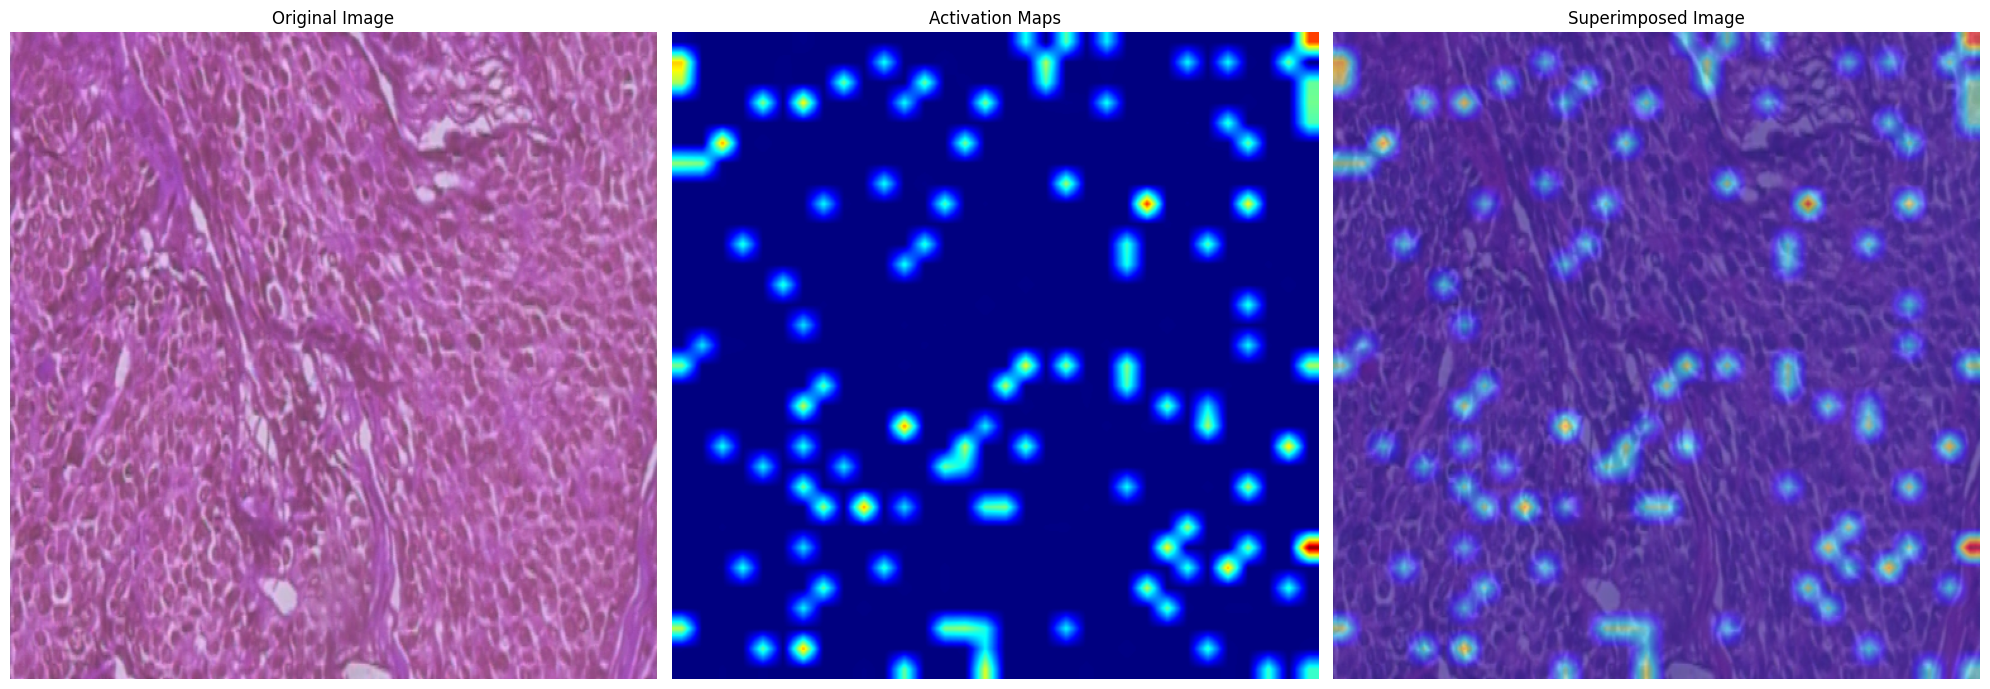

In [135]:
# Plot all images
plot_images(np_img, mask, heatmap)

In [90]:
cv2.imwrite("XAI_images/mask_image.jpg", heatmap)
print(f"Mask image saved")

Mask image saved
